# <center> Advanced ML pipeline with segmentation_models and Callbacks
    
---

In [1]:
import numpy as np

# Importing libraries

In [2]:
from matplotlib import pyplot as plt  # Displaying images
from skimage.io import imread         # Read the images
import numpy as np                    # Data Handling
import datetime                       # Used in Naming
import math                           # Math operations
import os                             # Directory files

# One Hot Encoded Mask and Dataset Building
from tensorflow.keras.utils import to_categorical, Sequence
import tensorflow as tf
import keras

# warnings
import warnings
warnings.filterwarnings('ignore')

2024-09-03 15:16:19.212532: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 15:16:19.212591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 15:16:19.215700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set the root directory paths for images and masks
img_dir = '/kaggle/input/images/render'
mask_dir = '/kaggle/input/images/clean'

# Sort the files in root directories, Create and Store the complete image and mask paths
images = [os.path.join(img_dir, x) for x in sorted(os.listdir(img_dir))]
masks = [os.path.join(mask_dir, x) for x in sorted(os.listdir(mask_dir))]


# First 8000 images to be used for training
X_train = images[:9000]
y_train = masks[:9000]

# Remaining can be used for validation purpose
X_valid = images[9000:-100]
y_valid = masks[9000:-100]

# Save some for testing purpose (last 4)
X_test = images[-100:]
y_test = masks[-100:]

In [4]:
len(X_test)

100

### Break Down of Mask Preprocessing


In [5]:
# Consider an example in training data to understand this
mask_sample_path = y_train[1]
print(mask_sample_path)

/kaggle/input/images/clean/clean0002.png


In [6]:
# Read the mask as gray scale
sample_mask_arr = imread(mask_sample_path, as_gray=True)
print(sample_mask_arr.shape)

(480, 720)


In [7]:
# Cropping the mask
sample_mask_cropped = sample_mask_arr[:480, :480]
print(sample_mask_cropped.shape)

(480, 480)


In [8]:
import tensorflow as tf

# Find the maximum and minimum pixel values
max_pixel_value = tf.reduce_max(sample_mask_cropped)
min_pixel_value = tf.reduce_min(sample_mask_cropped)

# Print the results
print(f'Maximum Pixel of Cropped Image: {max_pixel_value.numpy()}')
print(f'Minimum Pixel of Cropped Image: {min_pixel_value.numpy()}')


Maximum Pixel of Cropped Image: 0.7154
Minimum Pixel of Cropped Image: 0.0


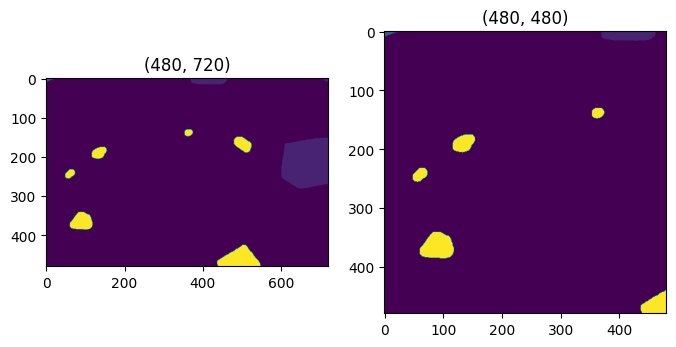

In [9]:
# Mask with original size and after cropping
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_data = ((sample_mask_arr, sample_mask_cropped),
            (sample_mask_arr.shape, sample_mask_cropped.shape))

for (ax, arr, title) in zip(axes,*(plot_data)) :
    ax.imshow(arr)
    ax.set_title(title)


In [10]:
# What happens if you divide them with 0.07?
np.unique(sample_mask_cropped)//0.07

array([ 0.,  1.,  3., 10.])

In [11]:
# We need to convert the values of 3 to 2 and 10 to 3 after floor operation with 0.07
adjusted_mask = sample_mask_cropped//0.07
adjusted_mask[adjusted_mask == 3.0] = 2.0
adjusted_mask[adjusted_mask == 10.0] = 3.0
print(np.unique(adjusted_mask))

[0. 1. 2. 3.]


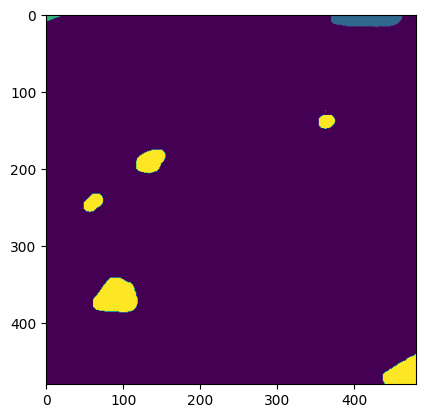

In [12]:
# Check if any changes in the output (the colors are a bit different! as pixel values changed)
plt.imshow(adjusted_mask)

In [13]:
# Get 4 channel one hot encoded mask
final_sample_mask = to_categorical(adjusted_mask,num_classes=4)
final_sample_mask

array([[[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       ...,

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0.

### Excercise to get from one hot to integer encoded mask (post processing)

In [14]:
final_sample_mask.shape

(480, 480, 4)

In [15]:
int_encoded_mask = np.argmax(final_sample_mask, axis=-1)
int_encoded_mask

array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3]])

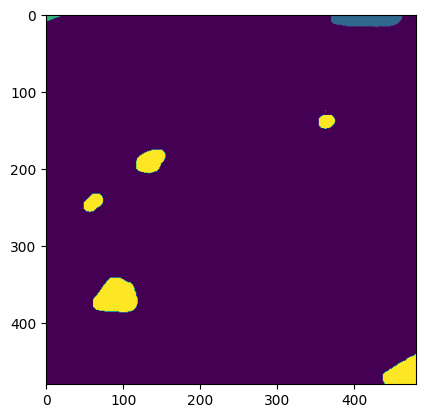

In [16]:
plt.imshow(int_encoded_mask)

In [17]:
# A dummy 4 channel array
np.random.seed(42)
dum_arr = np.random.rand(3, 3, 4)
dum_arr # 1, 3, 3, # 0, 1, 0 # 1, 2, 1

[1, 3, 3]
[0, 1, 0]
[1, 2, 2]

[1, 2, 2]

In [18]:
# First row has max value of 0.95 on index 1, hence, 1 is returned on (0,0)
# Similarly, second row has max value of 0.86 on index 3, hence 3 is returned for (0,1)
# So on ...
np.argmax(dum_arr, axis=-1)

array([[1, 3, 3],
       [0, 1, 0],
       [1, 2, 2]])

## Custom Data Generator to prepare the Dataset

In [19]:
# Dataset Pipeline
class LunarDataset(Sequence):

    # Constructor - x_set, y_set, batch_size, dims, classes
    def __init__(self, x_set, y_set, batch_size, dims, classes):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.img_height, self.img_width = dims
        self.classes = classes

    # Number of Batches --> total length of images / batch size --> Ceil operation
    def __len__(self):
        return math.ceil(len(self.x)/self.batch_size)

    # Fetch the data in batches by using iter and next opertions
    def __getitem__(self, idx):
        # Get start and end indexes to create a batch of batch size
        start_index = idx * self.batch_size
        end_index = (idx + 1) * self.batch_size
        '''
        0*2 : 1*2 --> 0:2 --> 0, 1
        1*2 : 2*2 --> 2:4 --> 2, 3
        2*2 : 3*2 --> 4:6 --> 4, 5
        '''

        # Prepare X and y batches
        batch_x = self.x[start_index : end_index]
        batch_y = self.y[start_index : end_index]

        # Empty lists to append preprocessed Images and Masks Array from the for loop
        xtr = []
        ytr = []

        # For every  image and mask in one batch do the following preprocessing
        for idx, (filename_x, filename_y) in enumerate(zip(batch_x, batch_y)):

            # Image preprocessing
            img = imread(filename_x)[:self.img_height, :self.img_width, :]/255.0
            img = img.astype(np.float32)
            xtr.append(img)

            # Mask preprocessing
            mask = imread(filename_y, as_gray=True)[:self.img_height, :self.img_width]//0.07 # 0, 1, 3, 10
            mask[mask == 3] = 2
            mask[mask == 10] = 3
            mask = to_categorical(mask, num_classes = self.classes)
            ytr.append(mask)

        # Convert list to arrays ensuring the dtype of mask is also float32
        xtr = np.array(xtr)
        ytr = np.array(ytr).astype(np.float32)

        # Return the preprocessed batch of images and respective mask as output
        return xtr, ytr

In [20]:
# Parameters
batch_size = 16
dims = (480, 480)
num_classes = 4

# Dataset Creation
train_dataset = LunarDataset(X_train, y_train, batch_size, dims, num_classes)
valid_dataset = LunarDataset(X_valid, y_valid, batch_size, dims, num_classes)

## Let's visualize our masks

In [21]:
# Taking a sample batch from train_dataset
batch = next(iter(train_dataset)) # Batch Size, Height, Width, Channels (Images, Masks)

# Check the shape of batch created --> Images and Masks
print(batch[0].shape) # 16 images in a batch
print(batch[1].shape) # 16 respective masks in a batch

(16, 480, 480, 3)
(16, 480, 480, 4)


In [22]:
# Get the mask
sample = batch[1][1] # Second in the batch

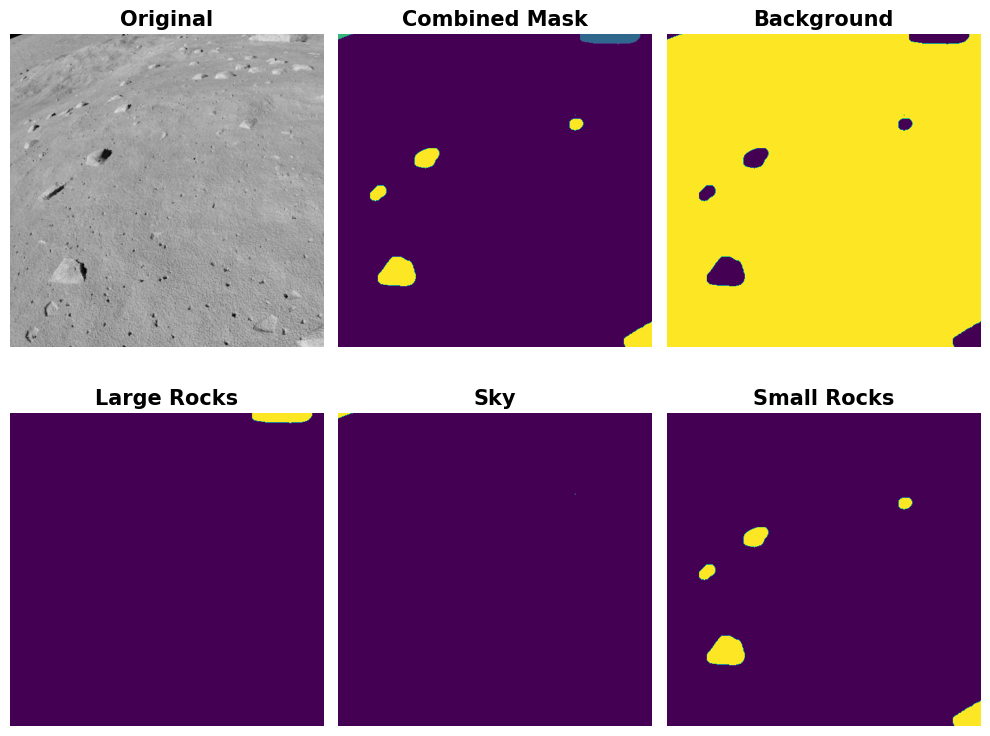

In [23]:
# Creating Subplot for better visualization
fig, ((a1, a2, a3), (a4, a5, a6)) = plt.subplots(2, 3, figsize = (10, 8))

# For different axes and titles
for i, (ax,title) in enumerate(zip((a1, a2, a3, a4, a5, a6),
                                   ('Original', 'Combined Mask', 'Background', 'Large Rocks', 'Sky', 'Small Rocks'))):
    if i == 0:
        ax.imshow(batch[0][1])                    # Second Image in the batch (Original)
    elif i == 1:
        ax.imshow(np.argmax(sample, axis=-1))     # Converts One Hot encoded mask to Integer Encoded Mask (single channel)
    else:
        ax.imshow(sample[:, :, i-2])              # Channel Wise Output from Mask

    # Set Title and turn off the axis
    ax.set_title(title, fontsize=15, weight='bold')
    ax.axis('off')

# Adjust Layout and Display the Subplot
plt.tight_layout()
plt.show()

### Let's check out some basic steps of transfer learning using a pretrained model (VGG16)


## segmentation_models

**segmentation_models** is a python library with Neural Networks for Image Segmentation based on Keras and TensorFlow.

The main features of this library are:

* High level API (just two lines of code to create model for segmentation)
* 4 models architectures for binary and multi-class image segmentation (including legendary Unet)
* 25 available backbones for each architecture
* All backbones have pre-trained weights for faster and better convergence
* Helpful segmentation losses (Jaccard, Dice, Focal) and metrics (IoU, F-score)

In [24]:
# run this command to directly install the library in our notebook

!pip install segmentation_models

* Provide environment variable SM_FRAMEWORK=keras / SM_FRAMEWORK=tf.keras before import segmentation_models
* Change framework sm.set_framework('keras') / sm.set_framework('tf.keras')

In [25]:
# By default it tries to import keras, if it is not installed, it will try to start with tensorflow.keras framework
os.environ["SM_FRAMEWORK"] = "tf.keras" # Set the environment variable SM_FRAMEWORK to "tf.keras"
import segmentation_models as sm        # It will import without any errors if env variable is set properly
sm.set_framework('tf.keras')            # Use segmentation_models library and set the framework to TensorFlow's Keras

Segmentation Models: using `tf.keras` framework.


In [26]:
# Set the last axis of the tensor as channel axis
tf.keras.backend.set_image_data_format('channels_last')
# Explicitly setting this is not always necessary, as 'channels_last' is the default setting

## Building our UNet model with segmentation_models

In [27]:
# Parameters for UNET using Segmentation Models
BACKBONE = 'seresnet50'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'


# Even though backbone doesn't have encoder-decoder structure, it is still able to build it thanks to sm library
model = sm.Unet(backbone_name = BACKBONE,
               input_shape = input_shape,
               classes = n_classes,
               activation = activation,
               encoder_weights = 'imagenet',
               encoder_freeze = True)

# Check all the different parameters of UNET, try with them
# Uncomment the above two lines of UNET for transfer learning

# Check the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 480, 480,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 486, 486,  │          0 │ input[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 240, 240,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 240, 240,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 240, 240,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 242, 242,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 120, 120,  │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 120, 120,  │      4,096 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 120, 120,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 122, 122,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 120, 120,  │     36,864 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 120, 120,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 120, 120,  │     16,384 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat

 Total params: 35,107,636 (133.93 MB)

 Trainable params: 9,066,628 (34.59 MB)

 Non-trainable params: 26,041,008 (99.34 MB)

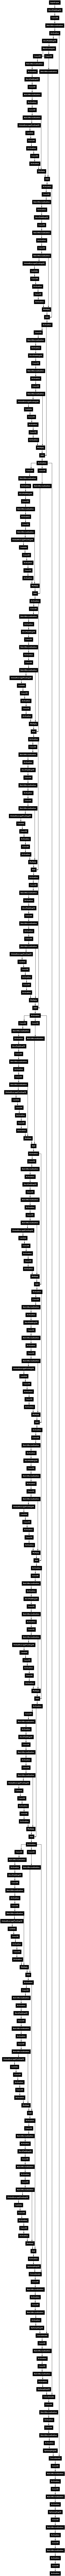

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'unet_seresnet50.png')

## Compile the model

In [29]:
# Import the Jaccard loss function
jaccard_loss = sm.losses.JaccardLoss()

In [30]:
""" Hyperparameters """
lr = 1e-4
batch_size = 16
epochs = 7

# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.3)]

# compiling the model --> Try changing the loss function to jacard_loss from sm library and see changes!
model.compile(loss = sm.losses.JaccardLoss(),
              optimizer = tf.keras.optimizers.RMSprop(lr),
              metrics = metrics)

# Steps per epoch (training in batches)
train_steps = len(X_train)//batch_size
valid_steps = len(X_valid)//batch_size


""" Callbacks """
callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_iou_score',
            mode = 'max',
            patience = 2,
            factor = 0.1,
            verbose = 1,
            min_lr = 1e-6
        ),

        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_iou_score',
            patience = 3,
            mode = 'max',
            verbose = 1
        )
    ]


- model is compiled with **loss**="categorical_crossentropy",  **optimizer**=Adam, **metrics**=iou_score

**Callbacks** is a tool to customize the behavior of a Keras model during training, evaluation, or inference.

**ReduceLROnPlateau:** Reduce learning rate when a metric has stopped improving.

**EarlyStopping:** Stop training when a monitored metric has stopped improving.

## Train the Model

In [31]:
# Fitting the model
model_history = model.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=callbacks)
    

Epoch 1/7


2024-09-03 15:17:53.493112: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,1024,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,2048,15,15]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-09-03 15:17:53.595225: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.102309527s
Trying algorithm eng0{} for conv (f32[16,1024,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,2048,15,15]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-09-03 15:17:54.616912: E exter

563/563 ━━━━━━━━━━━━━━━━━━━━ 633s 923ms/step - iou_score: 0.3993 - loss: 0.7069 - val_iou_score: 0.4678 - val_loss: 0.6007 - learning_rate: 1.0000e-04
Epoch 2/7
563/563 ━━━━━━━━━━━━━━━━━━━━ 390s 684ms/step - iou_score: 0.7154 - loss: 0.3395 - val_iou_score: 0.7560 - val_loss: 0.2523 - learning_rate: 1.0000e-04
Epoch 3/7
563/563 ━━━━━━━━━━━━━━━━━━━━ 390s 683ms/step - iou_score: 0.7722 - loss: 0.2317 - val_iou_score: 0.7624 - val_loss: 0.2375 - learning_rate: 1.0000e-04
Epoch 4/7
563/563 ━━━━━━━━━━━━━━━━━━━━ 395s 694ms/step - iou_score: 0.8039 - loss: 0.1978 - val_iou_score: 0.7823 - val_loss: 0.2216 - learning_rate: 1.0000e-04
Epoch 5/7
563/563 ━━━━━━━━━━━━━━━━━━━━ 387s 678ms/step - iou_score: 0.8170 - loss: 0.1842 - val_iou_score: 0.7792 - val_loss: 0.2236 - learning_rate: 1.0000e-04
Epoch 6/7
563/563 ━━━━━━━━━━━━━━━━━━━━ 383s 673ms/step - iou_score: 0.8302 - loss: 0.1707 - val_iou_score: 0.7953 - val_loss: 0.2068 - learning_rate: 1.0000e-04
Epoch 7/7
563/563 ━━━━━━━━━━━━━━━━━━━━ 386s 

## Generate Prediction
* We shall also use this code in our API to build our Streamlit webapp using FastAPI.

In [38]:
# function to predict result
def predict_image(img_path, mask_path, model):
    ## Basic Setup
    H = 480
    W = 480
    num_classes = 4

    ## Read Images and Preprocess
    img = imread(img_path)
    img = img[:W, :H]
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask and Preprocess
    mask = imread(mask_path, as_gray = True)
    mask = mask[:W, :H]

    ## Prediction mask and Postprocess
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]


    ## Calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum()/union.sum()

    return img, mask, pred_mask, iou

In [39]:
X_test[0], y_test[0]

('/kaggle/input/images/render/render9667.png',
 '/kaggle/input/images/clean/clean9667.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


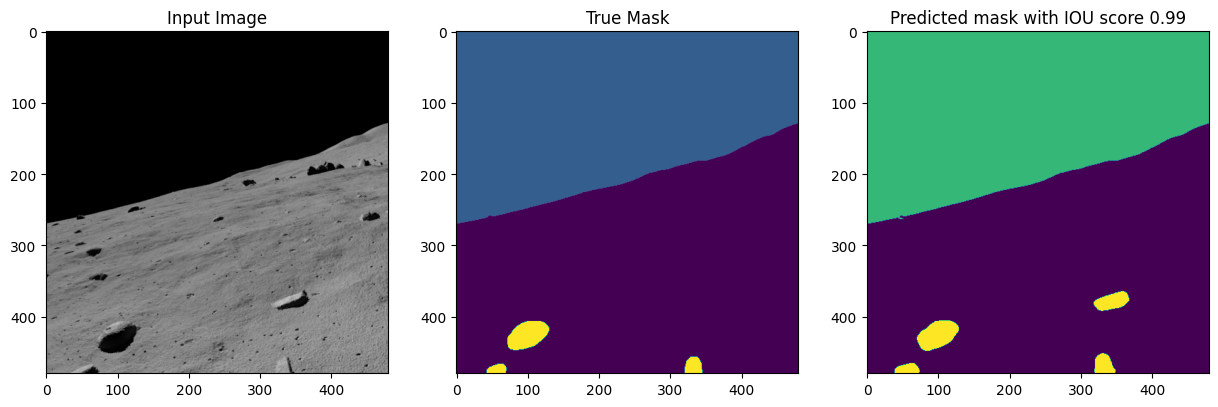

In [40]:
index_test = 0
img_path = X_test[index_test]
mask_path = y_test[index_test]

img, mask, pred_mask, iou = predict_image(img_path, mask_path, model)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title("Predicted mask with IOU score %.2f"%(iou))
ax3.imshow(pred_mask)

plt.show()

## Save the Model
* Once satisfied with the model performance, you can save the model.

In [41]:
from tensorflow.keras.models import load_model, save_model

In [42]:
# Save the Model
save_model(model, 'seresnet50LunarModel.h5')

In [9]:
from tabulate import tabulate
import pandas as pd

# ANSI escape codes for coloring
BLACK_TEXT = '\033[30m'
WHITE_BG = '\033[47m'
RESET = '\033[0m'

# Create the table with multi-line entries
table = {
    'Changes Made': [ 
        'loss=Jaccard loss\nBackbone=seresnet50\nthreshold=0.3\nOptimizer=RMSprop\nepochs=7', 
        'loss=dice loss\nBackbone=seresnet50\nthreshold=0.3\nOptimizer=RMSprop\nepochs=7',
        'loss=Jaccard loss\nBackbone=resnet50\nthreshold=0.3\nOptimizer=Adam\nepochs=7',
        'loss=Jaccard loss\nBackbone=efficientnetb3\nthreshold=0.3\nOptimizer=RMSprop\nepochs=7'
    ],
    'Train IOU': ['0.8827', '0.8424', '0.80', '0.8101'],
    'Val IOU': ['0.803', '0.7948', '0.799', '0.763'],
    'Test IOU': ['0.99', '0.99', '0.99', '0.86']
}

# Convert the dictionary to a DataFrame
table = pd.DataFrame(table)

# Add an index column
table.insert(0, 'Index', range(1, 1 + len(table)))

# Highlight the 2nd index row (3rd row in zero-based index)
table.loc[0] = [BLACK_TEXT + WHITE_BG + str(item) + RESET for item in table.loc[0]]

# Display the table using tabulate
print(tabulate(table, headers='keys', tablefmt='fancy_grid', showindex=False))


╒═════════╤═════════════════════════╤═════════════╤═══════════╤════════════╕
│   Index │ Changes Made            │   Train IOU │   Val IOU │   Test IOU │
╞═════════╪═════════════════════════╪═════════════╪═══════════╪════════════╡
│       1 │ loss=Jaccard loss       │      0.8827 │    0.803  │       0.99 │
│         │ Backbone=seresnet50     │             │           │            │
│         │ threshold=0.3           │             │           │            │
│         │ Optimizer=RMSprop       │             │           │            │
│         │ epochs=7                │             │           │            │
├─────────┼─────────────────────────┼─────────────┼───────────┼────────────┤
│       2 │ loss=dice loss          │      0.8424 │    0.7948 │       0.99 │
│         │ Backbone=seresnet50     │             │           │            │
│         │ threshold=0.3           │             │           │            │
│         │ Optimizer=RMSprop       │             │           │            │

/tmp/ipykernel_36/2556031037.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  table.loc[0] = [BLACK_TEXT + WHITE_BG + str(item) + RESET for item in table.loc[0]]


## THE END